In [57]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
rna_sequnce = ['ACT','GTU' , 'AUN']

In [4]:
def encode_seq(kmer_token):

    # A 1 0 0 0
    # C 0 1 0 0
    # T/U 0 0 0 1
    # G 0 0 1 0
    # N 0 0 0 0

    encoding_dict = {
        'A': [1, 0, 0, 0],
        'C': [0, 1, 0, 0],
        'G': [0, 0, 1, 0],
        'T': [0, 0, 0, 1],
        'U': [0, 0, 0, 1],
        'N': [0, 0, 0, 0],
    }

    encoded_sequence = []
    for  base in kmer_token:
        encoded_sequence.append(encoding_dict[base])
    return np.array(encoded_sequence).flatten()

x = []
for seq in rna_sequnce:
    x.append(encode_seq(seq))
x = torch.from_numpy( np.array(x))
x

tensor([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], dtype=torch.int32)

In [5]:
labels = ['red','blue','green']
le = LabelEncoder()
y = le.fit_transform(labels)
y = torch.from_numpy(np.array(y))
y 

tensor([2, 0, 1])

# Single Directional LSTM

In [28]:
hidden_dim = 3
embedding_dim = 7
input_dim = 12

embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True )
fc = nn.Linear(hidden_dim, 3) 

In [29]:
embedding_out =  embedding(x)
print(embedding_out.shape)

torch.Size([3, 12, 7])


In [30]:
lstm_out , (h,c) = lstm(embedding_out)

print(h.shape)
h[-1] # In case of Bi Directional use both output

torch.Size([1, 3, 3])


tensor([[ 0.2008,  0.0720, -0.1406],
        [ 0.2047,  0.0723, -0.1446],
        [ 0.0957, -0.0391, -0.1759]], grad_fn=<SelectBackward0>)

In [9]:
outputs = fc(h[-1])
outputs

tensor([[0.3529, 0.3054, 0.3562],
        [0.3561, 0.3049, 0.3573],
        [0.2824, 0.2879, 0.4239]], grad_fn=<AddmmBackward0>)

In [24]:

_, predicted = torch.max(outputs,1)
predicted

tensor([2, 2, 2])

In [11]:
loss_function = nn.CrossEntropyLoss()
loss = loss_function(outputs, y)
loss.item()

1.1024527549743652

# Bi-Directional LSTM with Attention

In [12]:
hidden_dim = 3
embedding_dim = 7
input_dim = 12

b_embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
b_lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True , bidirectional=True )
b_fc = nn.Linear(2*hidden_dim, 3) 

In [13]:
b_embedding_out =  embedding(x)
print(b_embedding_out.shape)

torch.Size([3, 12, 7])


In [14]:
b_lstm_out , (h,c) = lstm(embedding_out)

#       [[[ 0.1242,  0.0155,  0.1971],
#          [ 0.1305,  0.0160,  0.2074],
#          [ 0.1432, -0.0180, -0.1529]],

#         [[ 0.0721, -0.3585, -0.2495],
#          [-0.0041, -0.4517, -0.1265],
#          [ 0.0710, -0.3557, -0.2356]]]

b_h = torch.cat((h[-2, :, :], h[-1, :, :]), dim=1)
b_h

IndexError: index -2 is out of bounds for dimension 0 with size 1

In [ ]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(BahdanauAttention, self).__init__()
        self.W = nn.Linear(hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden.unsqueeze(1)
        hidden = hidden.expand(-1, encoder_outputs.size(1), -1)
        # Aboe two steps makes hidden dim similar to encoder_outputs
        
        alignment_scores = self.v(torch.tanh(self.W(hidden + encoder_outputs)))
        attention_weights = F.softmax(alignment_scores, dim=1)
        context_vector = torch.sum(attention_weights * encoder_outputs, dim=1)
        return context_vector, attention_weights

In [ ]:
attention = BahdanauAttention(2*hidden_dim)
context_vector , weights = attention(b_h , b_lstm_out)
context_vector

tensor([[-0.3244,  0.2820, -0.0638,  0.2010, -0.1485,  0.0028],
        [-0.3227,  0.2817, -0.0600,  0.2047, -0.1535, -0.0042],
        [-0.3397,  0.2763, -0.0792,  0.1829, -0.1382,  0.0202]],
       grad_fn=<SumBackward1>)

In [ ]:
outputs = fc(context_vector)
outputs

tensor([[ 0.3206, -0.0334,  0.1136],
        [ 0.3347, -0.0262,  0.1085],
        [ 0.3144, -0.0332,  0.1178]], grad_fn=<AddmmBackward0>)

In [ ]:
_, predicted = torch.max(outputs,1)
predicted

tensor([0, 0, 0])

In [ ]:
loss_function = nn.CrossEntropyLoss()
loss = loss_function(outputs, y)
loss.item()

1.106108546257019

# Mult Task Learning

In [21]:
y

tensor([2, 0, 1])

In [16]:
input_dim = 4
embedding_dim = 7
input_dim = 12
hidden_dim = 4
NUM_OF_TASK = 13

embedding = nn.Embedding(input_dim, embedding_dim, padding_idx=0)
lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim, num_layers=1, batch_first=True )
single_fc = nn.Linear(hidden_dim, 1) 
fc = nn.ModuleList([nn.Linear(hidden_dim, 1) for _ in range(NUM_OF_TASK)])

In [17]:
embedding_output = embedding(x)
embedding_output.shape

torch.Size([3, 12, 7])

In [18]:
_ , (h,c) = lstm(embedding_output)

h[-1].squeeze(1)

tensor([[-0.1643, -0.1124, -0.3511,  0.0965],
        [-0.1668, -0.1027, -0.3458,  0.1072],
        [-0.0681, -0.0747, -0.1766, -0.0564]], grad_fn=<SqueezeBackward1>)

In [19]:
single_out = single_fc(h[-1])
single_out.squeeze(1)

tensor([ 0.0042,  0.0044, -0.1065], grad_fn=<SqueezeBackward1>)

In [20]:
out = []
for f in fc:
    out.append(f(h[-1]).squeeze(1)) 
out

[tensor([-0.3979, -0.3976, -0.3621], grad_fn=<SqueezeBackward1>),
 tensor([-0.3789, -0.3762, -0.3885], grad_fn=<SqueezeBackward1>),
 tensor([-0.3479, -0.3481, -0.3315], grad_fn=<SqueezeBackward1>),
 tensor([-0.0605, -0.0617,  0.0079], grad_fn=<SqueezeBackward1>),
 tensor([0.3570, 0.3542, 0.4484], grad_fn=<SqueezeBackward1>),
 tensor([0.0742, 0.0665, 0.0307], grad_fn=<SqueezeBackward1>),
 tensor([0.0525, 0.0505, 0.0390], grad_fn=<SqueezeBackward1>),
 tensor([-0.3235, -0.3171, -0.4136], grad_fn=<SqueezeBackward1>),
 tensor([0.3545, 0.3545, 0.3280], grad_fn=<SqueezeBackward1>),
 tensor([-0.2060, -0.2086, -0.0886], grad_fn=<SqueezeBackward1>),
 tensor([0.2204, 0.2177, 0.2997], grad_fn=<SqueezeBackward1>),
 tensor([0.3070, 0.3031, 0.3697], grad_fn=<SqueezeBackward1>),
 tensor([-0.3657, -0.3579, -0.3856], grad_fn=<SqueezeBackward1>)]

In [31]:
import torch

data = [
    [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,0.],
    [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,0.],
    [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,0.]
  
]

labels = torch.tensor(data)

loss_functions = [nn.BCEWithLogitsLoss() for _ in range(NUM_OF_TASK)] 

loss =  0.0
for i, (output, loss_func) in enumerate(zip(out, loss_functions)):
    print("Output " ,output)
    print("Label " ,labels[:, i])
    loss += loss_func(output, labels[:, i])


Output  tensor([-0.3979, -0.3976, -0.3621], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 1.])
Output  tensor([-0.3789, -0.3762, -0.3885], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([-0.3479, -0.3481, -0.3315], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([-0.0605, -0.0617,  0.0079], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([0.3570, 0.3542, 0.4484], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([0.0742, 0.0665, 0.0307], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([0.0525, 0.0505, 0.0390], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([-0.3235, -0.3171, -0.4136], grad_fn=<SqueezeBackward1>)
Label  tensor([1., 1., 0.])
Output  tensor([0.3545, 0.3545, 0.3280], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tensor([-0.2060, -0.2086, -0.0886], grad_fn=<SqueezeBackward1>)
Label  tensor([0., 0., 0.])
Output  tens

In [65]:
# Prediction
import torch.nn.functional as F

total = 0
correct_predictions = [0] * NUM_OF_TASK

predicted_with_highest_probabilities = []

predicted = [torch.sigmoid(output) for output in out]

final_predicted_lables = torch.stack(predicted).T

max_indices = torch.argmax(final_predicted_lables, dim=1)

# Convert indices to one-hot encoded tensor
one_hot_tensor = F.one_hot(max_indices, num_classes=final_predicted_lables.shape[1])

print(one_hot_tensor.to(torch.float))
print(labels)

correct_predictions = torch.sum((one_hot_tensor == labels).float(), dim=0)

print(correct_predictions)

total  = labels.size(0)
validation_accuracies = []
for correct in correct_predictions:
    print(correct)
    validation_accuracies.append(correct/total)

validation_accuracies

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([2., 3., 3., 3., 1., 3., 3., 1., 2., 3., 3., 3., 3.])
tensor(2.)
tensor(3.)
tensor(3.)
tensor(3.)
tensor(1.)
tensor(3.)
tensor(3.)
tensor(1.)
tensor(2.)
tensor(3.)
tensor(3.)
tensor(3.)
tensor(3.)


[tensor(0.6667),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.3333),
 tensor(1.),
 tensor(1.),
 tensor(0.3333),
 tensor(0.6667),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.)]

c:\Users\shashi.vish\Python Environment\RNA_ModX\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\shashi.vish\AppData\Local\Temp\ipykernel_1964\1883817169.py:26: RuntimeWarning: Mean of empty slice.
  class_accuracies = [(np.array(original_preds)[np.array(original_labels) == i] == i).mean() for i in RMs]
c:\Users\shashi.vish\Python Environment\RNA_ModX\lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


['hGm' 'hm5C' 'hGm']
['hm1A' 'hm1A' 'Atol']
Accuracy for class hAm: nan
Accuracy for class hCm: nan
Accuracy for class hGm: nan
Accuracy for class hTm: nan
Accuracy for class hm1A: 0.0
Accuracy for class hm5C: nan
Accuracy for class hm5U: nan
Accuracy for class hm6A: nan
Accuracy for class hm6Am: nan
Accuracy for class hm7G: nan
Accuracy for class hPsi: nan
Accuracy for class Atol: 0.0
Accuracy for class NonMoD: nan


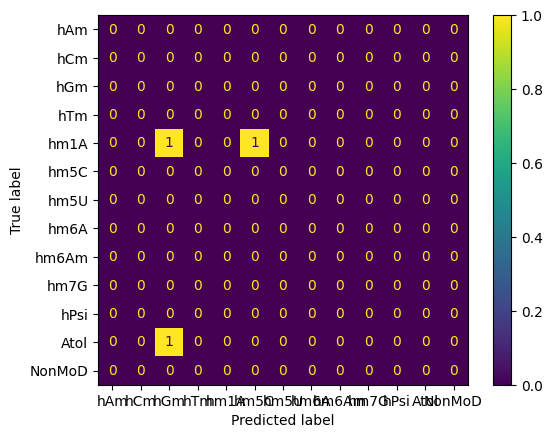

In [67]:
RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)
y = ohe.fit_transform(np.array(RMs).reshape(-1, 1)) # adding reshape here

original_preds = []
original_labels = []

original_preds.extend(ohe.inverse_transform(one_hot_tensor.cpu().numpy()))  
original_labels.extend(ohe.inverse_transform(labels.cpu().numpy()))



cm = confusion_matrix(original_labels, original_preds, labels=RMs)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=RMs)
disp.plot()

original_preds = np.array(original_preds).flatten()
original_labels = np.array(original_labels).flatten()

print(original_preds)
print(original_labels)

class_accuracies = [(np.array(original_preds)[np.array(original_labels) == i] == i).mean() for i in RMs]
for rm, acc in zip(RMs, class_accuracies):
    print(f"Accuracy for class {rm}: {acc}")

